In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.style.use('science')
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import scipy.io as io
from pyDOE import lhs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from complexPyTorch.complexLayers import ComplexLinear

import cplxmodule
from cplxmodule import cplx
from cplxmodule.nn import RealToCplx, CplxToReal, CplxSequential, CplxToCplx
from cplxmodule.nn import CplxLinear, CplxModReLU, CplxAdaptiveModReLU, CplxModulus, CplxAngle

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from lightning_utils import *
from utils import *
from models import (TorchComplexMLP, ImaginaryDimensionAdder, cplx2tensor, 
                    ComplexTorchMLP, ComplexSymPyModule, complex_mse)
from models import RobustPCANN
from pytorch_robust_pca import *
from preprocess import *

# Model selection
# from sparsereg.model import STRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from RegscorePy.bic import bic

from madgrad import MADGRAD
import lookahead

# BayesianOptimization
from bayes_opt import BayesianOptimization
from skopt import Optimizer

from tqdm import trange

Running Python 3.9.8
You can use npar for np.array


In [2]:
# torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You're running on", device)

# Adding noise
noise_intensity = 0.01/np.sqrt(2)
noisy_xt = False

# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

DATA_PATH = '../experimental_data/NLS.mat'
data = io.loadmat(DATA_PATH)

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = to_column_vector(Exact_u.T)
v_star = to_column_vector(Exact_v.T)

N = 500
idx = np.random.choice(X_star.shape[0], N, replace=False)
# idx = np.arange(N) # Just have an easy dataset for experimenting

lb = to_tensor(lb, False).to(device)
ub = to_tensor(ub, False).to(device)

# if noisy_xt:
#     print("Noisy (x, t)")
#     X_star = perturb(X_star, intensity=noise_intensity, noise_type="normal")
# else: print("Clean (x, t)")

# X_train = to_tensor(X_star[idx, :], True).to(device)
# u_train = to_tensor(u_star[idx, :], False).to(device)
# v_train = to_tensor(v_star[idx, :], False).to(device)

feature_names = ['hf', '|hf|', 'h_xx']

### Loading (clean) data code here ###
print("Loading pre-calculated (clean) data for reproducibility")
X_train = np.load("./tmp_files/X_train_500+500samples.npy")

if noise_intensity > 0.0 and noisy_xt:
    print("Noisy (x, t)")
    X_train = perturb(X_train, intensity=noise_intensity, noise_type="normal")
else: print("Clean (x, t)")

X_train = to_tensor(X_train, True)[:N, :]

uv_train = np.load("./tmp_files/uv_train_500samples.npy")
u_train = uv_train[:, 0:1]; v_train = uv_train[:, 1:2]

You're running on cpu
Loading pre-calculated (clean) data for reproducibility
Clean (x, t)


In [3]:
if noise_intensity > 0.0:
    noise_u = perturb(u_train, intensity=noise_intensity, noise_type="normal", overwrite=False)
    u_train = u_train + noise_u
    noise_v = perturb(v_train, intensity=noise_intensity, noise_type="normal", overwrite=False)
    v_train = v_train + noise_v
    print("Perturbed u_train and v_train with intensity =", float(noise_intensity))
u_train = u_train[:N, :]; v_train = v_train[:N, :]

u_train, v_train = to_tensor(u_train, False), to_tensor(v_train, False)
h_train = torch.complex(u_train, v_train)

Perturbed u_train and v_train with intensity = 0.0070710678118654745


In [4]:
cn1 = -0.020763+1.029535*1j
cn2 = -0.016447+0.509700*1j
cns = [cn1, cn2]

In [5]:
# Type the equation got from the symbolic regression step
# No need to save the eq save a pickle file before
program1 = "X0*X1"
pde_expr1, variables1,  = build_exp(program1); print(pde_expr1, variables1)

program2 = "X2"
pde_expr2, variables2,  = build_exp(program2); print(pde_expr2, variables2)

mod = ComplexSymPyModule(expressions=[pde_expr1, pde_expr2], complex_coeffs=cns); mod.train()

X0*X1 {X1, X0}
X2 {X2}


ComplexSymPyModule(
  (sympymodule): SymPyModule(expressions=(X0*X1, X2))
)

In [6]:
class RobustComplexPINN(nn.Module):
    def __init__(self, model, loss_fn, index2features, scale=False, lb=None, ub=None, init_cs=(-1.0, 0.0), init_betas=(0.0, 0.0)):
        super(RobustComplexPINN, self).__init__()
        # FFTNN
        global N
        self.in_fft_nn = FFTTh(c=init_cs[0], func=lambda x:(torch.exp(-F.relu(x))))
        self.out_fft_nn = FFTTh(c=init_cs[1], func=lambda x:(torch.exp(-F.relu(x))))
        
        self.model = model
        
        # Beta-Robust PCA
        self.inp_rpca = RobustPCANN(beta=init_betas[0], is_beta_trainable=True, inp_dims=2, hidden_dims=32)
        self.out_rpca = RobustPCANN(beta=init_betas[1], is_beta_trainable=True, inp_dims=2, hidden_dims=32)

        self.callable_loss_fn = loss_fn
        self.index2features = index2features; self.feature2index = {}
        for idx, fn in enumerate(self.index2features): self.feature2index[fn] = str(idx)
        self.scale = scale; self.lb, self.ub = lb, ub
        if self.scale and (self.lb is None or self.ub is None):
            print("Please provide thw lower and upper bounds of your PDE.")
            print("Otherwise, there will be error(s)")
        self.diff_flag = diff_flag(self.index2features)
        
    def forward(self, H):
        if self.scale: H = self.neural_net_scale(H)
        return self.model(H)
    
    def loss(self, HL, HS, y_input, y_input_S, update_network_params=True, update_pde_params=True):
        total_loss = []
        
        # Denoising FFT on (x, t)
        HS = cat(torch.fft.ifft(self.in_fft_nn(HS[1])*HS[0]).real.reshape(-1, 1), 
                 torch.fft.ifft(self.in_fft_nn(HS[3])*HS[2]).real.reshape(-1, 1))
        HS = HL-HS
        
        # Denoising FFT on y_input
        y_input_S = y_input-torch.fft.ifft(self.out_fft_nn(y_input_S[1])*y_input_S[0]).reshape(-1, 1)
        
        H = self.inp_rpca(HL, HS, normalize=True)
        
        y_input = self.out_rpca(cat(y_input.real, y_input.imag), 
                                cat(y_input_S.real, y_input_S.imag), 
                                normalize=True)
        y_input = torch.complex(y_input[:, 0:1], y_input[:, 1:2])
        
        grads_dict, u_t = self.grads_dict(H[:, 0:1], H[:, 1:2])
        
        # MSE Loss
        if update_network_params:
            total_loss.append(complex_mse(grads_dict['X'+self.feature2index['hf']], y_input))
        # PDE Loss
        if update_pde_params:
            total_loss.append(complex_mse(self.callable_loss_fn(grads_dict), u_t))
            
        return total_loss
    
    def grads_dict(self, x, t):
        uf = self.forward(cat(x, t))
        u_t = complex_diff(uf, t)
        
        ### PDE Loss calculation ###
        # Without calling grad
        derivatives = {}
        for t in self.diff_flag[0]:
            if t=='hf': 
                derivatives['X'+self.feature2index[t]] = cplx2tensor(uf)
                derivatives['X1'] = (uf.real**2+uf.imag**2)+0.0j
            elif t=='x': derivatives['X'+self.feature2index[t]] = x
        # With calling grad
        for t in self.diff_flag[1]:
            out = uf
            for c in t:
                if c=='x': out = complex_diff(out, x)
                elif c=='t': out = complex_diff(out, t)
            derivatives['X'+self.feature2index['h_'+t[::-1]]] = out
        
        return derivatives, u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))
    
    # Must ensure that the implementation of neural_net_scale is consistent
    # and hopefully correct
    # also, you might not need this function in some datasets
    def neural_net_scale(self, inp): 
        return 2*(inp-self.lb)/(self.ub-self.lb)-1

In [7]:
inp_dimension = 2
act = CplxToCplx[torch.tanh]
complex_model = CplxSequential(
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 1, bias=True),
                            )
complex_model = torch.nn.Sequential(
                                    torch.nn.Linear(inp_dimension, 200),
                                    RealToCplx(),
                                    complex_model
                                    )

In [8]:
# Pretrained model
semisup_model_state_dict = cpu_load("./saved_path_inverse_nls/noisy_NLS_complex_model_500labeledsamples_jointtrainwith500unlabeledsamples.pth")
parameters = OrderedDict()

# Filter only the parts that I care about renaming (to be similar to what defined in TorchMLP).
inner_part = "network.model."
for p in semisup_model_state_dict:
    if inner_part in p:
        parameters[p.replace(inner_part, "")] = semisup_model_state_dict[p]
complex_model.load_state_dict(parameters)

<All keys matched successfully>

In [9]:
def closure():
    global X_train, X_train_S, h_train, h_train_S, x_fft, x_PSD, t_fft, t_PSD
    if torch.is_grad_enabled():
        optimizer2.zero_grad(set_to_none=True)
    losses = pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), h_train, (h_train_fft, h_train_PSD), update_network_params=True, update_pde_params=True)
    l = sum(losses)
    if l.requires_grad: 
        l.backward(retain_graph=True)
    return l

def mtl_closure():
    global X_train, X_train_S, h_train, h_train_S, x_fft, x_PSD, t_fft, t_PSD
    n_obj = 2 # There are two tasks
    losses = pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), h_train, (h_train_fft, h_train_PSD), update_network_params=True, update_pde_params=True)
    updated_grads = []
    
    for i in range(n_obj):
        optimizer1.zero_grad(set_to_none=True)
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in list(pinn.inp_rpca.parameters())+list(pinn.out_rpca.parameters())+list(pinn.model.parameters())+list(pinn.callable_loss_fn.parameters()):
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(list(pinn.inp_rpca.parameters())+list(pinn.out_rpca.parameters())+list(pinn.model.parameters())+list(pinn.callable_loss_fn.parameters())):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    return sum(losses)

#### Finding the best thresold wrt to the first-epoch loss

In [10]:
noise_x, x_fft, x_PSD = fft1d_denoise(X_train[:, 0:1], c=0, return_real=True)
noise_x = X_train[:, 0:1]-noise_x
noise_t, t_fft, t_PSD = fft1d_denoise(X_train[:, 1:2], c=0, return_real=True)
noise_t = X_train[:, 1:2]-noise_t
X_train_S = cat(noise_x, noise_t)

h_train_S, h_train_fft, h_train_PSD = fft1d_denoise(h_train, c=-1, return_real=False)
h_train_S = h_train-h_train_S

del noise_x, noise_t
### ----- ###

In [11]:
pinn = RobustComplexPINN(model=complex_model, loss_fn=mod, 
                         index2features=feature_names, scale=False, lb=lb, ub=ub, 
                         init_cs=(0.9, 0.9), init_betas=(1.0, 1.0))

# relative_l2_error(h_pred, h_star) = 0.0017535249585142534
pinn_weights = "./saved_path_inverse_nls/cleanall_final_finetuned_doublebetarpca_fftthcpinnV2.pth"

# relative_l2_error(h_pred, h_star) = 0.004375546803510899
# pinn_weights = "./saved_path_inverse_nls/noisy_final_finetuned_doublebetarpca_fftthcpinnV2.pth"

# relative_l2_error(h_pred, h_star) = 0.011608216651073767
# pinn_weights = "./saved_path_inverse_nls/noisy2_final_finetuned_doublebetarpca_fftthcpinnV2.pth"

pinn = load_weights(pinn, pinn_weights)

Loaded the model's weights properly


In [12]:
h_star = np.sqrt(u_star**2 + v_star**2)

In [13]:
h_pred = pinn(to_tensor(X_star)).detach().numpy()
h_pred = np.sqrt(h_pred.real**2 + h_pred.imag**2)

In [14]:
relative_l2_error(h_pred, h_star)

0.0017535249585142534

In [15]:
h_star = h_star.reshape(X.shape)
h_pred = h_pred.reshape(X.shape)

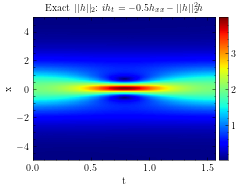

In [16]:
fig, ax = plt.subplots(1, 1)

h = ax.imshow(h_star.T, interpolation='nearest', cmap='jet', 
          extent=[lb[1], ub[1], lb[0], ub[0]], 
          origin='lower', aspect='auto')

ax.set_title("Exact $||h||_{2}$: $ih_t = -0.5h_{xx}-||h||^{2}_{2}h$", fontsize = 10)
ax.set_xlabel('t')
ax.set_ylabel('x')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig("./vis_pics/Exact_Dynamics.png", dpi=300)
plt.show()

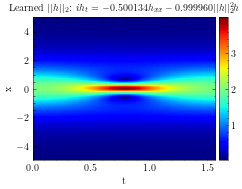

In [17]:
fig, ax = plt.subplots(1, 1)

h = ax.imshow(h_pred.T, interpolation='nearest', cmap='jet', 
          extent=[lb[1], ub[1], lb[0], ub[0]], 
          origin='lower', aspect='auto')

ax.set_title("Learned $||h||_{2}$: $ih_t = -0.500134h_{xx}-0.999960||h||^{2}_{2}h$", fontsize = 10)
ax.set_xlabel('t')
ax.set_ylabel('x')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig("./vis_pics/Learned_Dynamics_cleanall.png", dpi=300)
plt.show()

In [28]:
# est_coeffs = pinn.callable_loss_fn.complex_coeffs().detach().numpy().ravel()
# print(est_coeffs)
# # est_coeffs = npar([8.1524391e-05+0.9902236j, 5.3029885e-03+0.49562332j])
# grounds = np.array([1j, 0+0.5j])

# errs = []
# for i in range(len(grounds)):
#     err = est_coeffs[i]-grounds[i]
#     errs.append(100*abs(err.imag)/abs(grounds[i].imag))
# errs = np.array(errs)
# errs.mean(), errs.std()

[ 0.00067096+1.0004205j -0.00044082+0.5008436j]


(0.10538101196289062, 0.06333589553833008)

In [29]:
# U + Noise
# array([0.00118875+0.9984036j, 0.00168767+0.4998621j], dtype=complex64)
# (0.09360909461975098, 0.06603002548217773)
# (Parameter containing:
#  tensor([-0.0012], requires_grad=True),
#  Parameter containing:
#  tensor([-0.0022], requires_grad=True))

# U + Noise | (x, t) + Noise
# (1)
# array([8.1524391e-05+0.9902236j, 5.3029885e-03+0.49562332j], dtype=complex64)
# (0.9264880000000031, 0.051151999999998754)
# (Parameter containing:
#  tensor([0.5776], requires_grad=True),
#  Parameter containing:
#  tensor([-1.0001], requires_grad=True))
# (2) (func=lambda x:(torch.exp(-F.relu(x))))
# [0.00497404+0.99919987j 0.00771778+0.49703848j]
# (0.33615827560424805, 0.25614500045776367)
# (Parameter containing:
#  tensor([-0.1508], requires_grad=True),
#  Parameter containing:
#  tensor([-0.0031], requires_grad=True))

# U + Noise | (x, t) + Noise | "./saved_path_inverse_nls/noisy2_final_finetuned_doublebetarpca_fftthcpinnV2.pth"
# U + Noise | (x, t) + Noise
# (1)
# [0.00297839+1.0081341j  0.00733745+0.50027394j]
# (0.4341006278991699, 0.37931203842163086)
# (Parameter containing:
#  tensor([-0.0341], requires_grad=True),
#  Parameter containing:
#  tensor([-0.0313], requires_grad=True))
# (2) (func=lambda x:(torch.exp(-F.relu(x))))
# [ 0.00067096+1.0004205j -0.00044082+0.5008436j]
# (0.10538101196289062, 0.06333589553833008)
# (Parameter containing:
#  tensor([-0.0026], requires_grad=True),
#  Parameter containing:
#  tensor([0.0011], requires_grad=True))

#### Results

In [32]:
# Noisy Exact & Clean (x, t)
# (0.05885958671569824, 0.021964311599731445)
# array([-0.00046226+0.99919176j, -0.00056662+0.49981552j], dtype=complex64)
# Noisy Exact & Noisy (x, t)
# (0.6996273994445801, 0.01595020294189453)
# array([0.00149273+0.9928442j, 0.00079829+0.5034184j], dtype=complex64)

# Noisy Exact & Clean (x, t) & X_star = X_star-X_star_S
# (0.7112264633178711, 0.00553131103515625)
# array([ 3.449592e-03+1.007057j , -7.125967e-05+0.5035838j], dtype=complex64)
# Noisy Exact & Noisy (x, t) & X_star = X_star-X_star_S
# (0.7093071937561035, 0.0036716461181640625)
# array([ 3.4442921e-03+1.0070564j, -5.4004795e-05+0.5035649j], dtype=complex64)

# Noisy Exact & Clean (x, t) & X_star = X_star_L+1*X_star_S
# (0.1215517520904541, 0.08192658424377441)
# array([-8.2360100e-05+0.99960375j, -6.1671366e-05+0.5010174j], dtype=complex64)
# Noisy Exact & Noisy (x, t) & X_star = X_star_L+1*X_star_S
# (0.511014461517334, 0.25589466094970703)
# array([-0.01472272+1.0076691j, -0.02164156+0.5012756j], dtype=complex64)

# Noisy Exact & Noisy (x, t) & X_train = X_train_L+1*1*X_train_S+beta*NN(X_train_S)
# (0.5050361156463623, 0.1848280429840088)
# array([ 0.00107117+1.0032021j, -0.01103256+0.5034493j], dtype=complex64)
# beta = 0.005178438033908606

# Notes
# X_star = X_star-X_star_S -> Seems robust but not stable
# X_star = X_star_L+X_star_S -> The best?

In [33]:
### New results on Double Beta-RobustFFT ###
# Noisy Exact & Clean (x, t)
# array([-4.01791149e-05+0.9997733j, 1.09734545e-04+0.5006671j], dtype=complex64)
# (0.07804334163665771, 0.05537569522857666)
# (pinn.inp_rpca.beta Parameter containing:
#  tensor([0.0085], requires_grad=True),
#  pinn.out_rpca.beta Parameter containing:
#  tensor([0.0027], requires_grad=True))

# Noisy Exact & Noisy (x, t)
# array([0.00171628+1.0023999j, 0.00308448+0.5002444j], dtype=complex64)
# (0.14443397521972656, 0.09555816650390625)
# (Parameter containing:
#  tensor([0.0029], requires_grad=True),
#  Parameter containing:
#  tensor([0.0012], requires_grad=True))
# --- V2 ---
# array([0.00039933+1.0002806j, 0.00156634+0.5011481j], dtype=complex64)
# (0.12884140014648438, 0.10077953338623047)
# (Parameter containing:
#  tensor([0.9966], requires_grad=True),
#  Parameter containing:
#  tensor([0.9989], requires_grad=True))

### Results on Double Beta-RobustPCA ###
# Noisy Exact & Clean (x, t)
# array([0.00077563+1.0028679j, 0.00166233+0.50137794j], dtype=complex64)
# (0.2811908721923828, 0.005602836608886719)
# (pinn.inp_rpca.beta Parameter containing:
#  tensor([-0.0002], requires_grad=True),
#  pinn.out_rpca.beta Parameter containing:
#  tensor([0.0002], requires_grad=True))

# Noisy Exact & Noisy (x, t)
# array([-0.00045199+1.0037338j, 0.00022461+0.5013247j], dtype=complex64)
# (0.31915903091430664, 0.05421638488769531)
# (pinn.inp_rpca.beta Parameter containing:
#  tensor([-0.0011], requires_grad=True),
#  pinn.out_rpca.beta Parameter containing:
#  tensor([-0.0002], requires_grad=True))